In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv


In [52]:
import random
import numpy as np
import math
import os
import sys


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Read Glove Embeddings

In [10]:
GLOVE_DIR = '../input/glove6b/glove.6B.300d.txt'
print(os.path.exists(GLOVE_DIR))
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR)
print(len(word_to_vec_map))

True
400000


# Data Pre-processing

In [11]:
data = pd.read_csv('../input/entity-annotated-corpus/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Mapping B-entity and I-entity to same entity. Training only on PER and GPE

In [12]:
label_map = {
    "B-per":"per",
    "I-per":"per",
    "B-eve":"O",
    "I-eve":"O",
    "B-org":"O",
    "I-org":"O",
    "B-art":"O",
    "I-art":"O",
    "B-nat":"O",
    "I-nat":"O",
    "B-gpe":"gpe",
    "I-gpe":"gpe",
    "B-geo":"gpe",
    "I-geo":"gpe",
    "B-tim":"O",
    "I-tim":"O",
    "O":"O",
}

In [13]:
import string
data['Word'] = data['Word'].str.translate(str.maketrans('','',string.punctuation))
data['Word'] = data['Word'].str.lower()
data['Tag'] = data['Tag'].map(label_map)

Compute token2idx, idx2token, tag2idx, idx2tag

Below code is from *https://www.kaggle.com/dvircohen0/ner-lstm?scriptVersionId=60236417&cellId=3*

In [14]:
from itertools import chain
count_tags = {}
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
        for i in vocab:
            if i not in count_tags:
                count_tags[i]=0
        for i in data['Tag'].to_list():
            count_tags[i] += 1
            
    for i in count_tags:
        print(i, count_tags[i])
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
        
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

gpe 61126
per 34241
O 953208


In [15]:
data['Word_idx'] = data['Word'].map(word_to_index)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,thousands,NNS,O,358481.0,2
1,NaN,of,IN,O,268046.0,2
2,NaN,demonstrators,NNS,O,120649.0,2
3,NaN,have,VBP,O,174642.0,2
4,NaN,marched,VBN,O,234138.0,2


In [16]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
data_group.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, gpe, O, O, O, O, O, gpe, O,...","[358481.0, 268046.0, 120649.0, 174642.0, 23413...","[2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, ..."
1,Sentence: 10,"[iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, O...","[192569.0, 268225.0, 319691.0, 357810.0, 14275...","[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,Sentence: 100,"[helicopter, gunships, saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, O, O, O, O, O, O, gpe, O, O, O, O, O, O...","[176329.0, 169259.0, 319134.0, 290058.0, 24443...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, ..."
3,Sentence: 1000,"[they, left, after, a, tense, hourlong, stando...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[357810.0, 219577.0, 47798.0, 43010.0, 355882....","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
4,Sentence: 10000,"[un, relief, coordinator, jan, egeland, said, ...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[gpe, O, O, per, per, O, O, O, gpe, O, gpe, O,...","[370622.0, 305053.0, 108674.0, 195458.0, 13404...","[0, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, ..."


Split the data into train and test set in 8:2 ratio

In [17]:
tokens = data_group['Word_idx'].tolist()
tags = data_group['Tag_idx'].tolist()
print(len(tokens), len(tags))

47959 47959


In [18]:
train_tokens = []
val_tokens = []
train_tags = []
val_tags = []
indices = list(range(len(tokens)))
random.shuffle(indices)
for i in indices:
    assert len(tokens[i]) == len(tags[i])
    if i%20!=0:
        train_tokens.append(tokens[i])
        train_tags.append(tags[i])
    else:
        val_tokens.append(tokens[i])
        val_tags.append(tags[i])
print("Train set size", len(train_tokens))
print("Val set size", len(val_tokens))

Train set size 45561
Val set size 2398


In [19]:
unique_tokens = len(word_to_index) # len(list(set(data['Word'].to_list())))
unique_tags = len(list(set(data['Tag'].to_list())))
PAD_IDX = unique_tokens+1
print(unique_tokens, unique_tags)

400000 3


# Data Iterator

Pad the input using PAD_IDX. Pad the output with -1. After this function all the sequences within a batch will have same length

In [21]:
def data_iterator(tokens, tags, batch_size, shuffle=False):
    order = list(range(len(tokens)))
    for i in range((len(tokens)+1)//batch_size):
        batch_sentences = [tokens[idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        batch_tags = [tags[idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        
        batch_max_len = max([len(s) for s in batch_sentences])

        batch_data = PAD_IDX*np.ones((len(batch_sentences), batch_max_len))
        batch_labels = -1*np.ones((len(batch_sentences), batch_max_len))

        for j in range(len(batch_sentences)):
            cur_len = len(batch_sentences[j])
            batch_data[j][:cur_len] = batch_sentences[j]
            batch_labels[j][:cur_len] = batch_tags[j]

        batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)
        batch_data = batch_data.transpose(0, 1).contiguous()
        batch_labels = batch_labels.transpose(0, 1).contiguous()
    
        batch_data, batch_labels = batch_data.cuda(), batch_labels.cuda()
        yield batch_data, batch_labels

In [22]:
train_data_iterator =  data_iterator(train_tokens, train_tags,4, shuffle=True)
train_batch, labels_batch = next(train_data_iterator)
print(train_batch.shape, labels_batch.shape)

torch.Size([26, 4]) torch.Size([26, 4])


# Load Glove Embeddings

In [23]:
vocab_len = len(word_to_index) + 2            
emb_dim = word_to_vec_map["cucumber"].shape[0]  
emb_matrix = np.zeros((vocab_len, emb_dim))
for word, index in word_to_index.items():
    emb_matrix[index, :] = word_to_vec_map[word]
print(emb_matrix.shape)

(400002, 300)


In [24]:
emb_matrix = torch.FloatTensor(emb_matrix)
embedding = torch.nn.Embedding.from_pretrained(emb_matrix,freeze=True)

# Transformer Model

In [25]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, hidden_dim, num_layers, num_labels, pad_idx, dropout=0.5, device="cuda"):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.encoder = embedding # nn.Embedding(vocab_size, embedding_size)
        self.pos_encoder = PositionalEncoding(embedding_size, dropout)
        encoder_layers = TransformerEncoderLayer(embedding_size, num_heads, hidden_dim, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(embedding_size, num_labels)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx
        self.embedding_size = embedding_size
        self.device = device


    def make_src_mask(self, src):
        # use src_mask to ignore pad indices embeddings while computing self-attention output
        src_mask = src.transpose(0, 1) == self.pad_idx
        return src_mask.to(self.device)

    def forward(self, src):
        src_mask = self.make_src_mask(src)
        src = self.encoder(src) * math.sqrt(self.embedding_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_mask)
        output = self.fc_out(output)
        return output


In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_index) + 2
num_classes = unique_tags
embedding_size = 300
num_heads = 6
num_layers = 6
dropout = 0.0
hidden_dim = 2048

In [28]:
model = TransformerModel(vocab_size, embedding_size, num_heads,hidden_dim, num_layers, num_classes, PAD_IDX, dropout, device).to(device)

In [29]:
!pip install torchsummaryX

In [30]:
from torchsummaryX import summary
summary(model, torch.zeros((20, 4)).long().cuda())

                                                   Kernel Shape  \
Layer                                                             
0_encoder                                         [300, 400002]   
1_pos_encoder.Dropout_dropout                                 -   
2_transformer_encoder.layers.0.Dropout_dropout1               -   
3_transformer_encoder.layers.0.LayerNorm_norm1            [300]   
4_transformer_encoder.layers.0.Linear_linear1       [300, 2048]   
5_transformer_encoder.layers.0.Dropout_dropout                -   
6_transformer_encoder.layers.0.Linear_linear2       [2048, 300]   
7_transformer_encoder.layers.0.Dropout_dropout2               -   
8_transformer_encoder.layers.0.LayerNorm_norm2            [300]   
9_transformer_encoder.layers.1.Dropout_dropout1               -   
10_transformer_encoder.layers.1.LayerNorm_norm1           [300]   
11_transformer_encoder.layers.1.Linear_linear1      [300, 2048]   
12_transformer_encoder.layers.1.Dropout_dropout               

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder,"[300, 400002]","[20, 4, 300]",NaN,NaN
1_pos_encoder.Dropout_dropout,-,"[20, 4, 300]",NaN,NaN
2_transformer_encoder.layers.0.Dropout_dropout1,-,"[20, 4, 300]",NaN,NaN
3_transformer_encoder.layers.0.LayerNorm_norm1,[300],"[20, 4, 300]",600.0,300.0
4_transformer_encoder.layers.0.Linear_linear1,"[300, 2048]","[20, 4, 2048]",616448.0,614400.0
5_transformer_encoder.layers.0.Dropout_dropout,-,"[20, 4, 2048]",NaN,NaN
6_transformer_encoder.layers.0.Linear_linear2,"[2048, 300]","[20, 4, 300]",614700.0,614400.0
7_transformer_encoder.layers.0.Dropout_dropout2,-,"[20, 4, 300]",NaN,NaN
8_transformer_encoder.layers.0.LayerNorm_norm2,[300],"[20, 4, 300]",600.0,300.0


# Training and Validation

In [31]:
def accuracy(outputs, labels):
    labels = labels.ravel()
    mask = (labels >= 0)
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs == labels)/float(np.sum(mask))
metrics = {
    'accuracy': accuracy,
}

In [32]:
from tqdm import trange
def train(model, optimizer, loss_fn, data_iterator, metrics, num_steps):
    model.train()
    summ = []
    t = trange(num_steps)
    for i in t:
        train_batch, labels_batch = next(data_iterator)
        output_batch = model(train_batch)
        output_batch = output_batch.view(output_batch.shape[0]*output_batch.shape[1], output_batch.shape[2])
        labels_batch = labels_batch.view(labels_batch.shape[0]*labels_batch.shape[1],)
        loss = loss_fn(output_batch, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 20 == 0:
            output_batch = output_batch.data.cpu().numpy()
            labels_batch = labels_batch.data.cpu().numpy()
            summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                             for metric in metrics}
            summary_batch['loss'] = loss.item()
            summ.append(summary_batch)

    metrics_mean = {metric: np.mean([x[metric]
                                     for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v)
                                for k, v in metrics_mean.items())
    print("- Train metrics: " + metrics_string)

In [33]:
def evaluate(model, loss_fn, data_iterator, metrics, num_steps):
    model.eval()
    summ = []
    for _ in range(num_steps):
        data_batch, labels_batch = next(data_iterator)
        output_batch = model(data_batch)
        output_batch = output_batch.view(output_batch.shape[0]*output_batch.shape[1], output_batch.shape[2])
        labels_batch = labels_batch.view(labels_batch.shape[0]*labels_batch.shape[1],)
        loss = loss_fn(output_batch, labels_batch)
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()
        summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                         for metric in metrics}
        summary_batch['loss'] = loss.item()
        summ.append(summary_batch)
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    print("- Eval metrics : " + metrics_string)
    return metrics_mean

Data is skewed. Compute class weights and pass it to cross entropy loss

In [34]:
total_tags = 0
for tag in count_tags:
    total_tags += count_tags[tag]
class_weights = [0 for _ in range(unique_tags)]
for tag, idx in tag2idx.items():
    class_weights[idx] = 1/count_tags[tag]
class_weights = torch.FloatTensor(class_weights).cuda()
print(class_weights)

tensor([1.6360e-05, 2.9205e-05, 1.0491e-06], device='cuda:0')


In [43]:
batch_size = 64
num_epochs = 20

In [36]:
def train_and_evaluate(model, train_tokens, train_tags, val_tokens, val_tags, optimizer, metrics):
    loss_fn = nn.CrossEntropyLoss(class_weights, ignore_index=-1, reduction='mean')
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        num_steps = (len(train_tokens) + 1) // batch_size
        train_data_iterator = data_iterator(train_tokens, train_tags, batch_size, shuffle=True)
        train(model, optimizer, loss_fn, train_data_iterator, metrics, num_steps)
        num_steps = (len(val_tokens) + 1) // batch_size
        val_data_iterator = data_iterator(val_tokens, val_tags, batch_size, shuffle=False)
        val_metrics = evaluate(model, loss_fn, val_data_iterator, metrics, num_steps)

In [37]:
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [44]:
train_and_evaluate(model, train_tokens, train_tags, val_tokens, val_tags, optimizer, metrics)

  0%|          | 3/711 [00:00<00:27, 25.65it/s]

Epoch 1/20


100%|██████████| 711/711 [00:29<00:00, 23.84it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.038


  0%|          | 3/711 [00:00<00:25, 27.73it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.651
Epoch 2/20


100%|██████████| 711/711 [00:29<00:00, 23.87it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.038


  0%|          | 3/711 [00:00<00:25, 27.62it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.670
Epoch 3/20


100%|██████████| 711/711 [00:29<00:00, 23.83it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.70it/s]

- Eval metrics : accuracy: 0.961 ; loss: 0.698
Epoch 4/20


100%|██████████| 711/711 [00:29<00:00, 23.88it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.88it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.716
Epoch 5/20


100%|██████████| 711/711 [00:29<00:00, 23.87it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.88it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.713
Epoch 6/20


100%|██████████| 711/711 [00:29<00:00, 23.85it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.98it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.734
Epoch 7/20


100%|██████████| 711/711 [00:29<00:00, 23.87it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.93it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.738
Epoch 8/20


100%|██████████| 711/711 [00:29<00:00, 23.72it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.035


  0%|          | 3/711 [00:00<00:25, 27.43it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.758
Epoch 9/20


100%|██████████| 711/711 [00:29<00:00, 23.88it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.035


  0%|          | 3/711 [00:00<00:25, 27.95it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.757
Epoch 10/20


100%|██████████| 711/711 [00:29<00:00, 23.97it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.036


  0%|          | 3/711 [00:00<00:27, 25.66it/s]

- Eval metrics : accuracy: 0.961 ; loss: 0.737
Epoch 11/20


100%|██████████| 711/711 [00:29<00:00, 23.92it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.036


  0%|          | 3/711 [00:00<00:25, 27.89it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.723
Epoch 12/20


100%|██████████| 711/711 [00:29<00:00, 23.88it/s]


- Train metrics: accuracy: 0.976 ; loss: 0.043


  0%|          | 3/711 [00:00<00:25, 27.88it/s]

- Eval metrics : accuracy: 0.959 ; loss: 0.644
Epoch 13/20


100%|██████████| 711/711 [00:29<00:00, 23.86it/s]


- Train metrics: accuracy: 0.972 ; loss: 0.053


  0%|          | 3/711 [00:00<00:25, 28.04it/s]

- Eval metrics : accuracy: 0.958 ; loss: 0.557
Epoch 14/20


100%|██████████| 711/711 [00:29<00:00, 23.91it/s]


- Train metrics: accuracy: 0.971 ; loss: 0.053


  0%|          | 3/711 [00:00<00:25, 27.72it/s]

- Eval metrics : accuracy: 0.958 ; loss: 0.544
Epoch 15/20


100%|██████████| 711/711 [00:29<00:00, 23.73it/s]


- Train metrics: accuracy: 0.973 ; loss: 0.048


  0%|          | 3/711 [00:00<00:25, 27.99it/s]

- Eval metrics : accuracy: 0.959 ; loss: 0.555
Epoch 16/20


100%|██████████| 711/711 [00:29<00:00, 23.81it/s]


- Train metrics: accuracy: 0.975 ; loss: 0.043


  0%|          | 3/711 [00:00<00:25, 27.48it/s]

- Eval metrics : accuracy: 0.959 ; loss: 0.613
Epoch 17/20


100%|██████████| 711/711 [00:29<00:00, 23.74it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.038


  0%|          | 3/711 [00:00<00:25, 27.51it/s]

- Eval metrics : accuracy: 0.960 ; loss: 0.645
Epoch 18/20


100%|██████████| 711/711 [00:29<00:00, 23.88it/s]


- Train metrics: accuracy: 0.977 ; loss: 0.035


  0%|          | 3/711 [00:00<00:25, 27.87it/s]

- Eval metrics : accuracy: 0.961 ; loss: 0.700
Epoch 19/20


100%|██████████| 711/711 [00:29<00:00, 23.85it/s]


- Train metrics: accuracy: 0.978 ; loss: 0.034


  0%|          | 3/711 [00:00<00:25, 27.93it/s]

- Eval metrics : accuracy: 0.962 ; loss: 0.711
Epoch 20/20


100%|██████████| 711/711 [00:29<00:00, 23.86it/s]


- Train metrics: accuracy: 0.979 ; loss: 0.034
- Eval metrics : accuracy: 0.961 ; loss: 0.717


In [45]:
from IPython.display import HTML
def create_download_link(title = "Download model file", filename = "./images.zip"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)


torch.save(model.state_dict(), "model_100.pth")
create_download_link(filename='./model_100.pth')

# Plot Confidence Matrix

In [46]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_conf_mat(model, tokens, tags):
    model.eval()
    summ = []
    conf_mat = np.zeros((unique_tags, unique_tags))
    print("unique_tags",unique_tags, conf_mat.shape)
    for idx in trange(len(tokens)):
        data = [tokens[idx]]
        labels = tags[idx]
        data = torch.LongTensor(data)
        data = data.transpose(0, 1).contiguous().cuda()
        outputs = model(data)
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1], outputs.shape[2])
        outputs = outputs.data.cpu().numpy()
        outputs = np.argmax(outputs, axis=1)
        for i, j in  zip(labels, outputs):
            conf_mat[i][j]+=1
            
    df_cm = pd.DataFrame(conf_mat, index = list(tag2idx.keys()), columns = list(tag2idx.keys()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    for i in range(unique_tags):
        print()
        print(idx2tag[i].upper())
        print("precision", conf_mat[i][i]/np.sum(conf_mat.T[i]))
        print("recall", conf_mat[i][i]/np.sum(conf_mat[i]))

  1%|          | 16/2398 [00:00<00:14, 158.88it/s]

unique_tags 3 (3, 3)


100%|██████████| 2398/2398 [00:15<00:00, 155.07it/s]



GPE
precision 0.71836398572605
recall 0.8677055702917772

PER
precision 0.7497267759562841
recall 0.8270042194092827

O
precision 0.9879965219604266
recall 0.9715542950094889


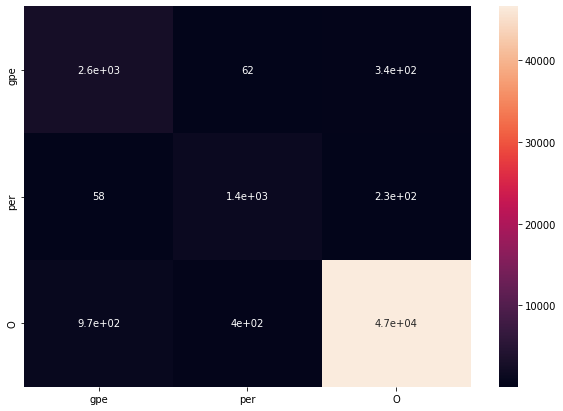

In [49]:
plot_conf_mat(model, val_tokens,val_tags)

# Prediction

In [48]:
model.load_state_dict(torch.load("./model_100.pth"))
model.eval()

TransformerModel(
  (encoder): Embedding(400002, 300)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
  

In [50]:
def predict(model, sentence):
    model.eval()
    words = sentence.translate(str.maketrans('','',string.punctuation)).split()
    data = [[word_to_index[word.lower()] for word in words]]
    data = torch.LongTensor(data)
    data = data.transpose(0, 1).contiguous().cuda()
    outputs = model(data)
    outputs = outputs.view(outputs.shape[0]*outputs.shape[1], outputs.shape[2])
    outputs = outputs.data.cpu().numpy()
    outputs = np.argmax(outputs, axis=1)
    ner = ""
    for i, j in enumerate(outputs):
        ner =  ner + " " + words[i]+"("+idx2tag[j].upper()+")"
    print(ner.strip())

In [51]:
input_sentence = "Carrie Mathison, a CIA operations officer, conducts an unauthorized operation in Iraq and is reassigned to the CIA's Counterterrorism Center in Langley, Virginia. Nicholas Brody, a U.S. Marine Sergeant who had been reported as missing in action since 2003, is rescued from a compound belonging to terrorist Abu Nazir. Brody is heralded as a war hero, but Carrie comes to suspect that he is planning a terrorist attack against the United States."
predict(model, input_sentence)

Carrie(PER) Mathison(O) a(O) CIA(O) operations(O) officer(O) conducts(O) an(O) unauthorized(O) operation(O) in(O) Iraq(GPE) and(O) is(O) reassigned(O) to(O) the(O) CIAs(O) Counterterrorism(O) Center(O) in(O) Langley(O) Virginia(GPE) Nicholas(O) Brody(PER) a(O) US(GPE) Marine(O) Sergeant(O) who(O) had(O) been(O) reported(O) as(O) missing(O) in(O) action(O) since(O) 2003(O) is(O) rescued(O) from(O) a(O) compound(O) belonging(O) to(O) terrorist(O) Abu(O) Nazir(O) Brody(PER) is(O) heralded(O) as(O) a(O) war(O) hero(O) but(O) Carrie(PER) comes(O) to(O) suspect(O) that(O) he(O) is(O) planning(O) a(O) terrorist(O) attack(O) against(O) the(O) United(GPE) States(GPE)
